# Sparse Hebbian Learning: toward a quantitative measure of the quality of filters

We are interested here in learning the "optimal" components of a set of images (let's say some "natural", usual images). As there is no supervisor to guide the learning, this is called unsupervised learning. Our basic hypothesis to find the best ("optimal") components will be to assume that *a priori* the most sparse is more plausible. We will implement the derived algorithm in this set of scripts.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(precision=4, suppress=True)

## experiments

To test and control for the role of different parameters, we will have a first object (in the [shl_experiments.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_experiments.py) script) that controls a learning experiment. It contains all relevant parameters, but can also keep a trace of the history of some statistics. This is useful to compare the relative efficiency of the different solutions.


In [3]:
DEBUG_DOWNSCALE, verbose = 10, 0
DEBUG_DOWNSCALE, verbose = 1, 0
DEBUG_DOWNSCALE, verbose = 10, 10
DEBUG_DOWNSCALE, verbose = 1, 10
#matname = 'HAP_quantization'
homeo_method = 'HEH'
tag = 'autoencoder'
matname = tag +'_' + homeo_method
opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, 
            homeo_method=homeo_method, eta_homeo=0.05, alpha_homeo=0.02, 
            C=5., nb_quant=128, P_cum=None, verbose=verbose)

In [4]:
from shl_scripts.shl_experiments import SHL
shl = SHL(**opts)
data = shl.get_data(matname='autoencoder')

Extracting data..No cache found data_cache/autoencoder_data: Extracting data... Extracting data..bittern62.png, reflection63.png, yose07.png, rocky10.png, koala52.png, craterlake12.png, clouds43.png, yellowleaves39.png, yose05.png, goldwater67.png, bird08.png, cattails70.png, flowers37.png, woods54.png, cucorn50.png, bora04.png, geyser27.png, flowerhill29.png, calcoast09.png, hibiscus30.png, Data is of shape : (81920, 169) - done in 8.24s.
Data is of shape : (81920, 169) - done in 8.43s.


In [5]:
!ls -l {shl.data_cache}/{tag}*

-rw-r--r--  1 laurentperrinet  staff  110755968 Feb 12 14:59 data_cache/autoencoder_data.npy


In [6]:
print('number of patches, size of patches = ', data.shape)
print('average of patches = ', data.mean(), ' +/- ', data.mean(axis=1).std())
SE = np.sqrt(np.mean(data**2, axis=1))
print('average energy of data = ', SE.mean(), '+/-', SE.std())

number of patches, size of patches =  (81920, 169)
average of patches =  -5.346012197420297e-05  +/-  0.006256733979835415
average energy of data =  0.060971410184194344 +/- 0.07082090813368663


In [7]:
shl.do_precision

False

## learning

The actual learning is done in a second object (here ``dico``) from which we can access another set of properties and functions  (see the [shl_learn.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_learn.py) script):

No cache found data_cache/autoencoder_HEH_dico.pkl: Learning the dictionary with algo = mp 
 Training on 81920 patches... Learning code... Iteration   1 /   8193 (elapsed time:   2s,   0mn   2s)
Iteration  129 /   8193 (elapsed time:  203s,   3mn  23s)
Iteration  257 /   8193 (elapsed time:  351s,   5mn  51s)
Iteration  385 /   8193 (elapsed time:  489s,   8mn   9s)
Iteration  513 /   8193 (elapsed time:  630s,  10mn  30s)
Iteration  641 /   8193 (elapsed time:  771s,  12mn  51s)
Iteration  769 /   8193 (elapsed time:  898s,  14mn  58s)
Iteration  897 /   8193 (elapsed time:  1026s,  17mn   6s)
Iteration  1025 /   8193 (elapsed time:  1151s,  19mn  11s)
Iteration  1153 /   8193 (elapsed time:  1273s,  21mn  13s)
Iteration  1281 /   8193 (elapsed time:  1396s,  23mn  16s)
Iteration  1409 /   8193 (elapsed time:  1523s,  25mn  23s)
Iteration  1537 /   8193 (elapsed time:  1639s,  27mn  19s)
Iteration  1665 /   8193 (elapsed time:  1757s,  29mn  17s)
Iteration  1793 /   8193 (elapsed time

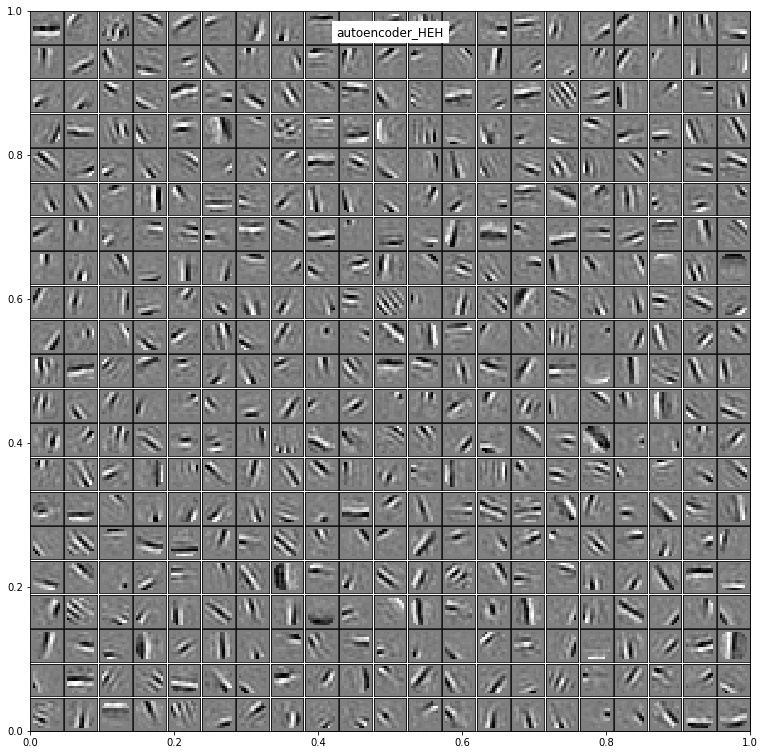

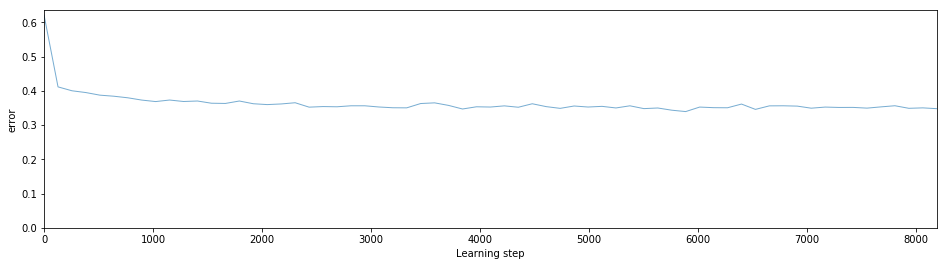

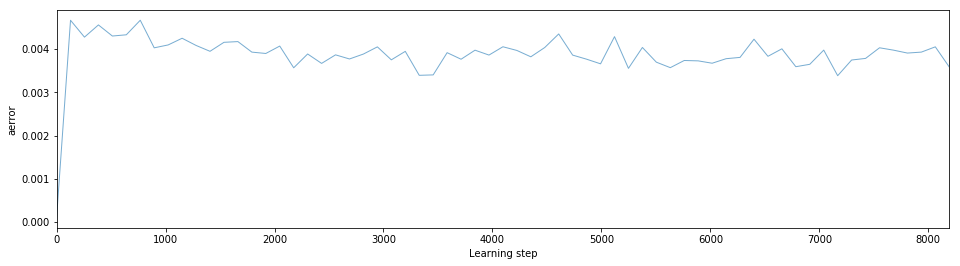

In [8]:
list_figures = ['show_dico', 'time_plot_error', 'time_plot_aerror']#, 'plot_variance',  'plot_variance_histogram',  'time_plot_prob',  'time_plot_kurt',  'time_plot_var']

dico = shl.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [9]:
print('size of dictionary = (number of filters, size of imagelets) = ', dico.dictionary.shape)
print('average of filters = ',  dico.dictionary.mean(axis=1).mean(), 
      '+/-',  dico.dictionary.mean(axis=1).std())
SE = np.sqrt(np.sum(dico.dictionary**2, axis=1))
print('average energy of filters = ', SE.mean(), '+/-', SE.std())

size of dictionary = (number of filters, size of imagelets) =  (441, 169)
average of filters =  0.00010912100067489288 +/- 0.004815870400653991
average energy of filters =  1.0 +/- 8.224293831200726e-17


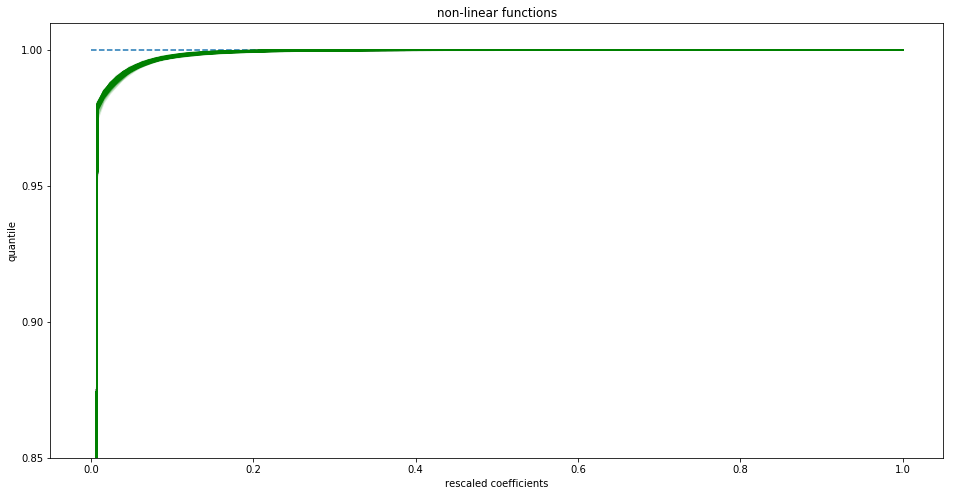

In [10]:
if not dico.P_cum is None: 
    from shl_scripts.shl_tools import plot_P_cum
    fig, ax = plot_P_cum(dico.P_cum, verbose=False, alpha=.15);
    ax.set_ylim(0.85, 1.01)
    #ax.set_xmargin(0.);

## coding

The learning itself is done via a gradient descent but is highly dependent on the coding / decoding algorithm. This belongs to a another function (in the [shl_encode.py](https://github.com/bicv/SHL_scripts/blob/master/shl_scripts/shl_encode.py) script)

In [11]:
nb_quant = shl.nb_quant
C = shl.C
l0_sparseness = 200
l0_sparseness = shl.l0_sparseness
record_num_batches = 2048
N_show = 120
max_patches = 10
stick = np.arange(shl.n_dictionary)*nb_quant

np.random.seed(42)
indx = np.random.permutation(data.shape[0])[:record_num_batches]
P_cum_zeroeffect = np.linspace(0, 1, nb_quant, endpoint=True)[np.newaxis, :] * np.ones((shl.n_dictionary, 1))


🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 441)
average of codewords =  0.005399920713300282
average std of codewords =  0.05298590069032672
l0-sparseness of codewords =  0.0335375035430839  ~= l0/M = 0.034013605442176874
std of the average of individual patches =  0.0013103026130479199
number of codes, size of reconstructed images =  (2048, 169)


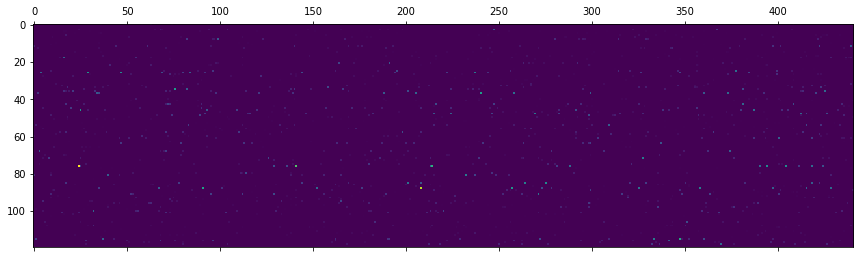

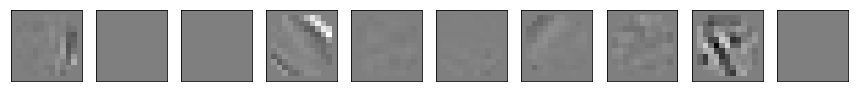

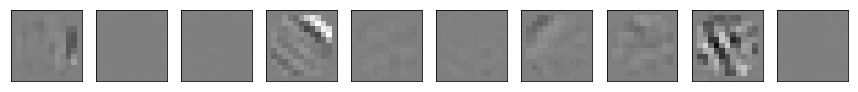

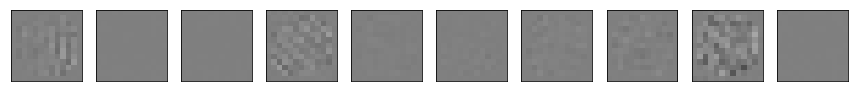

average of data patches =  -1.0042947495150989e-05 +/- 0.005973648630595939
average of residual patches =  -8.912577962733518e-05 +/- 0.003370037654812308
median energy of data =  0.03022854521092207
average energy of data =  0.05903749734484456 +/- 0.07012868733999604
average energy of residual =  0.0207346645228299 +/- 0.02429587873759939
median energy of residual =  0.010849687809864571
average gain of coding =  2.7676686705661635 +/- 0.5604682114304786
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 441)
average of codewords =  0.005399920713300282
average std of codewords =  0.05298590069032673
l0-sparseness of codewords =  0.0335375035430839  ~= l0/M = 0.034013605442176874
std of the average of individual patches =  0.00131030261304792
number of codes, size of reconstructed images =  (2048, 169)


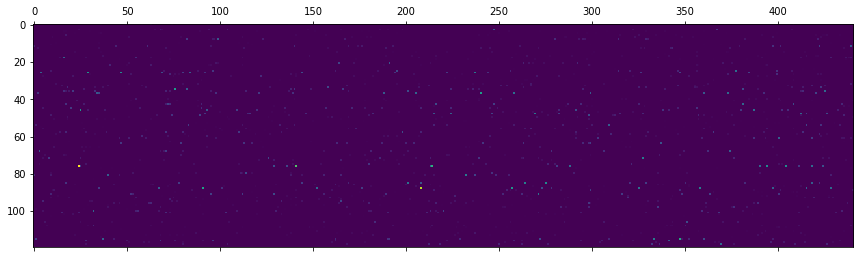

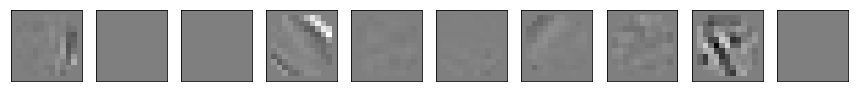

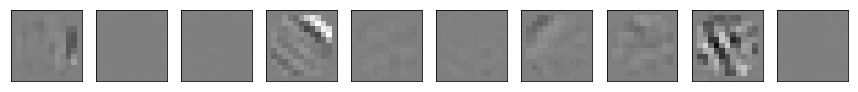

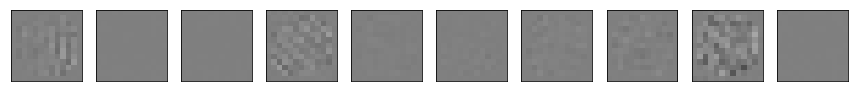

average of data patches =  -1.0042947495150989e-05 +/- 0.005973648630595939
average of residual patches =  -8.912577962733525e-05 +/- 0.003370037654812308
median energy of data =  0.03022854521092207
average energy of data =  0.05903749734484456 +/- 0.07012868733999604
average energy of residual =  0.0207346645228299 +/- 0.02429587873759939
median energy of residual =  0.01084968780986457
average gain of coding =  2.7676686705661635 +/- 0.5604682114304786
🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒🐒
number of codes, size of codewords =  (2048, 441)
average of codewords =  0.005405911053939824
average std of codewords =  0.05283924494094331
l0-sparseness of codewords =  0.033544146825396824  ~= l0/M = 0.034013605442176874
std of the average of individual patches =  0.0013527354151425344
number of codes, size of reconstructed images =  (2048, 169)


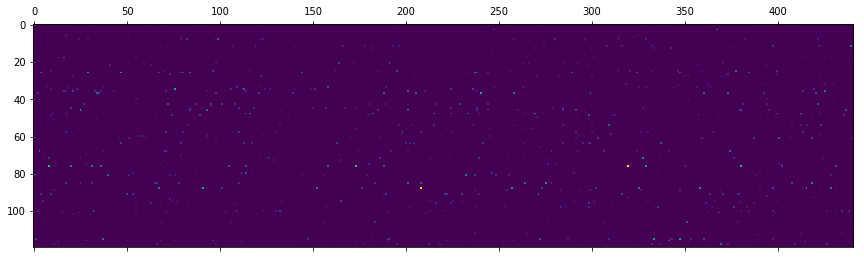

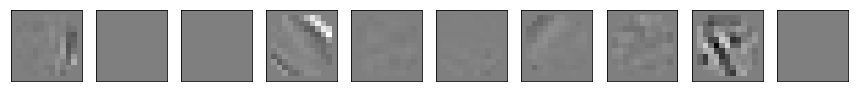

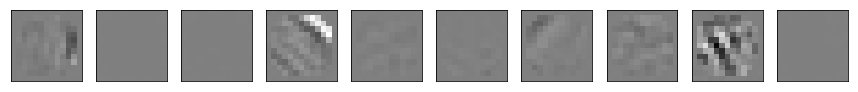

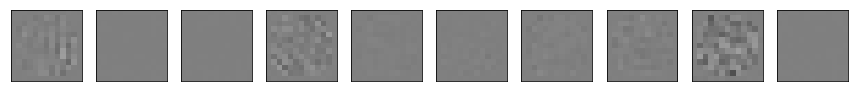

average of data patches =  -1.0042947495150989e-05 +/- 0.005973648630595939
average of residual patches =  -0.0002916735076888915 +/- 0.003775795532195293
median energy of data =  0.03022854521092207
average energy of data =  0.05903749734484456 +/- 0.07012868733999604
average energy of residual =  0.021079098736287695 +/- 0.024652454007180163
median energy of residual =  0.01135186421839947
average gain of coding =  2.7333021773240174 +/- 0.542081146536872


In [12]:
from shl_scripts.shl_encode import mp
if dico.P_cum is None: 
    gain = np.ones(shl.n_dictionary)
else:
    gain = None
for P_cum, gain in zip([None, P_cum_zeroeffect, dico.P_cum], [np.ones(shl.n_dictionary), None, gain]):
    print(50*'🐒')
    sparse_code = mp(data[indx, :], dico.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum, gain=gain)
    patches = sparse_code @ dico.dictionary
    error = data[indx, :] - patches

    print('number of codes, size of codewords = ', sparse_code.shape)
    print('average of codewords = ', sparse_code.mean())
    print('average std of codewords = ', sparse_code.std())
    print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl.l0_sparseness/shl.n_dictionary)
    print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

    print('number of codes, size of reconstructed images = ', patches.shape)

    from shl_scripts.shl_tools import show_data
    plt.matshow(sparse_code[:N_show, :])
    plt.show()
    fig, axs = show_data(data[indx, :][:max_patches, :])
    plt.show()
    fig, axs = show_data(patches[:max_patches, :])
    plt.show()
    fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(patches[:max_patches, :])))
    plt.show()
    print('average of data patches = ', data[indx, :].mean(), '+/-', data[indx, :].mean(axis=1).std())
    print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
    SD = np.sqrt(np.mean(data[indx, :]**2, axis=1))
    #SD = np.linalg.norm(data[indx, :])/record_num_batches

    print('median energy of data = ', np.median(SD))
    print('average energy of data = ', SD.mean(), '+/-', SD.std())
    #print('total energy of data = ', np.sqrt(np.sum(data**2)))
    #print('total deviation of data = ', np.sum(np.abs(data)))
    
    SE = np.sqrt(np.mean(error**2, axis=1))
    #SE = np.linalg.norm(error)/record_num_batches

    print('average energy of residual = ', SE.mean(), '+/-', SE.std())
    print('median energy of residual = ', np.median(SE))
    #print('total energy of residual = ', np.sqrt(np.sum(error**2)))
    #print('total deviation of residual = ', np.sum(np.abs(error)))
    print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())
    #print('average gain of coding = ', data[indx, :].std()/error.std())

## Shuffling the coefficients

In [13]:
print(sparse_code.shape)

(2048, 441)


In [14]:
help(np.random.shuffle)

Help on built-in function shuffle:

shuffle(...) method of mtrand.RandomState instance
    shuffle(x)
    
    Modify a sequence in-place by shuffling its contents.
    
    This function only shuffles the array along the first axis of a
    multi-dimensional array. The order of sub-arrays is changed but
    their contents remains the same.
    
    Parameters
    ----------
    x : array_like
        The array or list to be shuffled.
    
    Returns
    -------
    None
    
    Examples
    --------
    >>> arr = np.arange(10)
    >>> np.random.shuffle(arr)
    >>> arr
    [1 7 5 2 9 4 3 6 0 8]
    
    Multi-dimensional arrays are only shuffled along the first axis:
    
    >>> arr = np.arange(9).reshape((3, 3))
    >>> np.random.shuffle(arr)
    >>> arr
    array([[3, 4, 5],
           [6, 7, 8],
           [0, 1, 2]])



In [15]:
sparse_code_bar = sparse_code.copy()
#sparse_code_bar = sparse_code_bar.T
np.random.shuffle(sparse_code_bar)
#sparse_code_bar = sparse_code_bar.T
print('average non-zeros', np.count_nonzero(sparse_code_bar, axis=0))
print('average non-zeros', np.count_nonzero(sparse_code, axis=0))

average non-zeros [ 74  73  67  73  89  99  72  50  69  98  88  58  62  43  72  63 163  80
  93  34 135  47  80  63  74  61  50  55  65 116  77  54  51  82  68  71
  87  93  70  48  60  81  59  80  43  51  58  69  42  38  64  58  71  75
  55  83  82  70  54  48  57  50  52 105  52  54  70  56  95  48  71 110
 166 245  93  68  52  72  78  64 141  52  45  45  55  59  62  39  88  81
  61  57 116  91 102  83  63  66  46  44  50  65  47  70  51  55  50  57
  47  57  54  60  80  58  67  75  83  69  54 173  41  58  55  51  67  58
  54  77  61  36  68  70  46  72  50  65 158  72  74  66  50  45  51  43
 149  49  51  58  63  48  58  54  57 169  51  62  55  57  87  68  57  45
  63  64  91 230  63 242  49  62  54  91  52  75  62  51  43  55  63  57
  62  78  70  59  63  57  50  66 113  73  67  61  58  61  49  63  52  64
  65  50  69  77 174  62  79  81  53  77  71  61  63  47  67  68  52  58
  44  64  50  47 133  57  83  65  51  55 222  61  59  48  56  66  61  74
  64  81  50  71  58  74  57  79 

In [16]:
sparse_code[:N_show, 0], sparse_code_bar[:N_show, 0]

(array([0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.0002, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0374, 0.0001,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.0021,
        0.    , 0.3158, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
        0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 0.    , 

In [17]:
print(sparse_code_bar.shape)

(2048, 441)


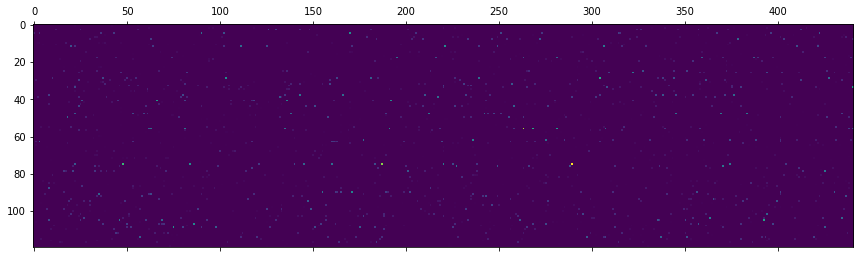

In [18]:
plt.matshow(sparse_code_bar[:N_show, :])

In [19]:
patches_bar = sparse_code_bar @ dico.dictionary

P_cum_rec = dico.P_cum
if dico.P_cum is None: 
    gain_rec = np.ones(shl.n_dictionary)
else:
    gain_rec = None #np.ones(shl.n_dictionary)

sparse_code_rec = mp(patches_bar, dico.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum_rec, gain=gain_rec)

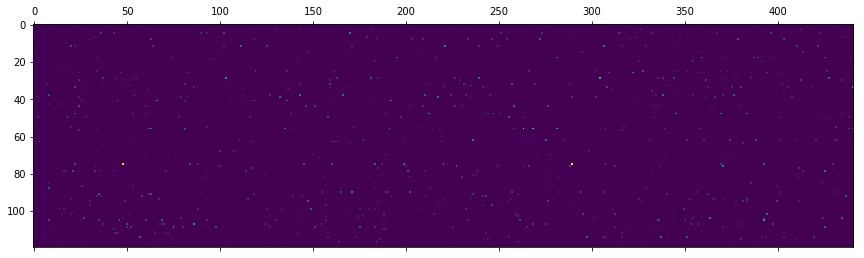

In [20]:
plt.matshow(sparse_code_rec[:N_show, :])

In [21]:
print('mean deviation of coefficients = ', np.mean(np.abs(sparse_code_bar)))
print('total deviation of coefficients = ', np.mean(np.abs(sparse_code_bar-sparse_code_rec)))

mean deviation of coefficients =  0.005405911053939823
total deviation of coefficients =  0.001783254292724777


In [22]:
if not dico.P_cum is None: 
    from shl_scripts.shl_encode import quantile, rescaling

    q_rec = quantile(dico.P_cum, rescaling(sparse_code_rec, C=C), stick, do_fast=False)
    q_bar = quantile(dico.P_cum, rescaling(sparse_code_bar, C=C), stick, do_fast=False)

    print('mean deviation of quantiles = ', np.mean(np.abs(q_bar)))
    print('total deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec)))

mean deviation of quantiles =  0.005035614283747591
total deviation of quantiles =  0.00169284360777292


In [23]:
print(' correct coefficients = ', np.mean( (sparse_code_bar>0) == (sparse_code_rec>0)))

 correct coefficients =  0.9894416099773242


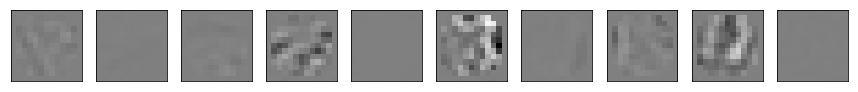

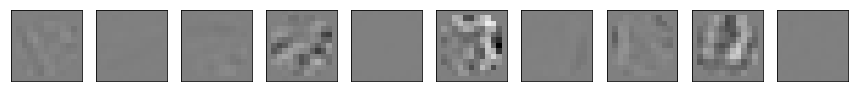

average of data patches =  0.00028163056019374057 +/- 0.005029637258753146
average of residual patches =  -5.38763976000697e-05 +/- 0.0013137570341354558
median energy of data =  0.027384408277932232
average energy of data =  0.05479689803076691 +/- 0.06583733765836745
average energy of residual =  0.008080960148266758 +/- 0.010849799923844923
median energy of residual =  0.0038276206245144283
average gain of coding =  7.658107385569281 +/- 3.6546872338555523


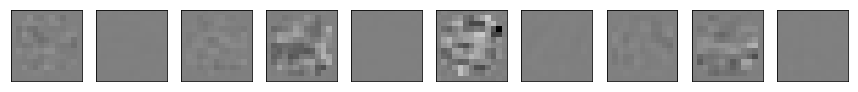

In [24]:
patches_rec = sparse_code_rec @ dico.dictionary
error = patches_bar - patches_rec
fig, axs = show_data(patches_bar[:max_patches, :], cmax=np.max(np.abs(patches_bar[:max_patches, :])))
plt.show()
fig, axs = show_data(patches_rec[:max_patches, :], cmax=np.max(np.abs(patches_bar[:max_patches, :])))
plt.show()
fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(error[:max_patches, :])))
print('average of data patches = ', patches_bar.mean(), '+/-', patches_bar.mean(axis=1).std())
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
SD = np.sqrt(np.mean(patches_bar**2, axis=1))
print('median energy of data = ', np.median(SD))
print('average energy of data = ', SD.mean(), '+/-', SD.std())

SE = np.sqrt(np.mean(error**2, axis=1))
print('average energy of residual = ', SE.mean(), '+/-', SE.std())
print('median energy of residual = ', np.median(SE))
#print('total energy of residual = ', np.sqrt(np.sum(error**2)))
#print('total deviation of residual = ', np.sum(np.abs(error)))
print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())

## comparing to the learning without homeostasis

Extracting data..loading the data called : data_cache/autoencoder_data
Data is of shape : (81920, 169) - done in 0.25s.
No cache found data_cache/autoencoder_None_dico.pkl: Learning the dictionary with algo = mp 
 Training on 81920 patches... Learning code... Iteration   1 /   8193 (elapsed time:   1s,   0mn   1s)
Iteration  129 /   8193 (elapsed time:  23s,   0mn  23s)
Iteration  257 /   8193 (elapsed time:  45s,   0mn  45s)
Iteration  385 /   8193 (elapsed time:  67s,   1mn   7s)
Iteration  513 /   8193 (elapsed time:  87s,   1mn  27s)
Iteration  641 /   8193 (elapsed time:  108s,   1mn  48s)
Iteration  769 /   8193 (elapsed time:  133s,   2mn  13s)
Iteration  897 /   8193 (elapsed time:  157s,   2mn  37s)
Iteration  1025 /   8193 (elapsed time:  180s,   3mn   0s)
Iteration  1153 /   8193 (elapsed time:  204s,   3mn  24s)
Iteration  1281 /   8193 (elapsed time:  228s,   3mn  48s)
Iteration  1409 /   8193 (elapsed time:  252s,   4mn  12s)
Iteration  1537 /   8193 (elapsed time:  277s,

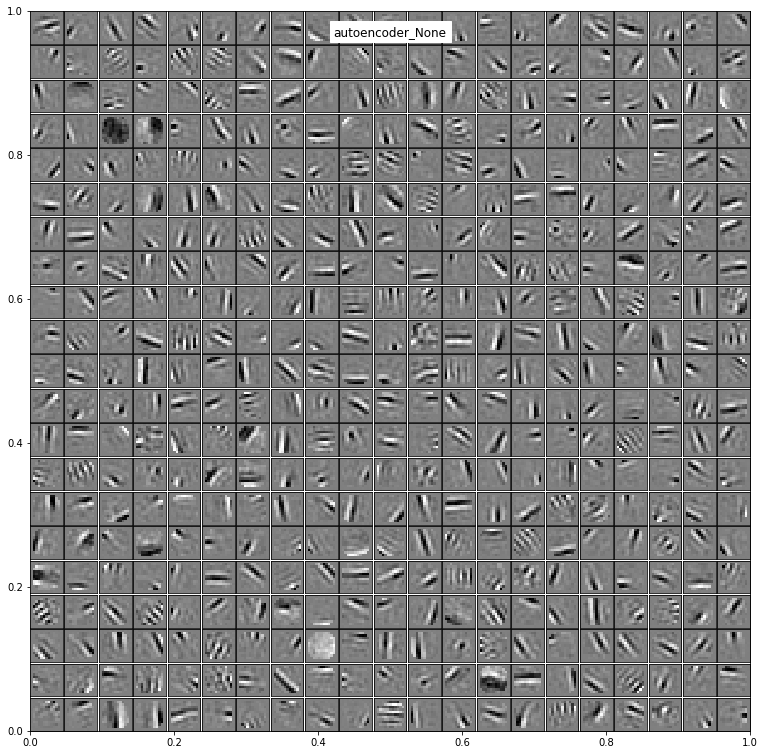

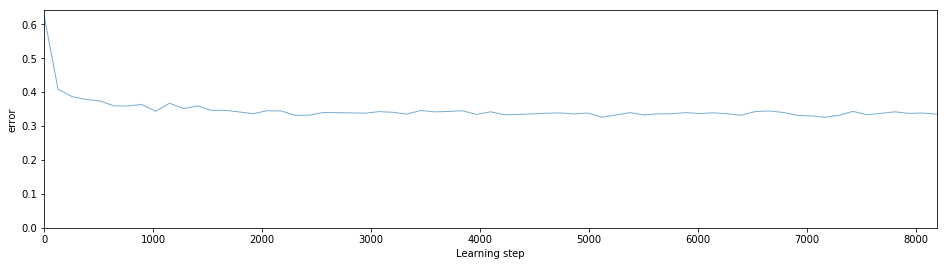

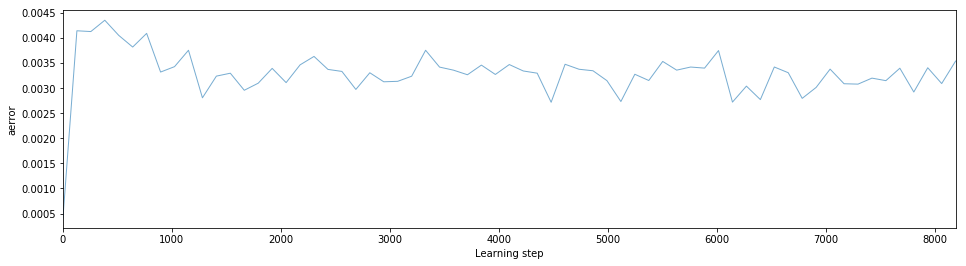

In [25]:
homeo_method = 'None'
matname = 'autoencoder_' + homeo_method
opts = dict(DEBUG_DOWNSCALE=DEBUG_DOWNSCALE, homeo_method=homeo_method, verbose=verbose)

from shl_scripts.shl_experiments import SHL
shl_nohomeo = SHL(**opts)
data = shl_nohomeo.get_data(matname='autoencoder')
dico_nohomeo = shl_nohomeo.learn_dico(data=data, list_figures=list_figures, matname=matname)

In [26]:
if not dico_nohomeo.P_cum is None: 
    from shl_scripts.shl_tools import plot_P_cum
    fig, ax = plot_P_cum(dico_nohomeo.P_cum, verbose=False, alpha=.15);
    ax.set_ylim(0.85, 1.01)
    #ax.set_xmargin(0.);

### coding


number of codes, size of codewords =  (2048, 441)
average of codewords =  0.005422679712987661
average std of codewords =  0.05319816659360602
l0-sparseness of codewords =  0.033926135558390025  ~= l0/M = 0.034013605442176874
std of the average of individual patches =  0.0013727713541320755
number of codes, size of reconstructed images =  (2048, 169)


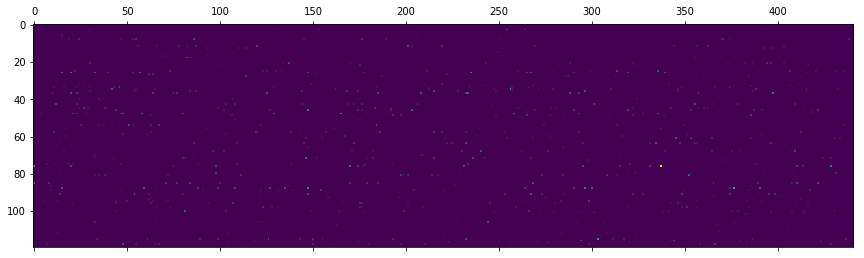

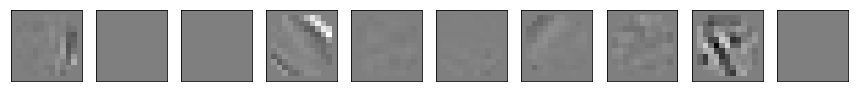

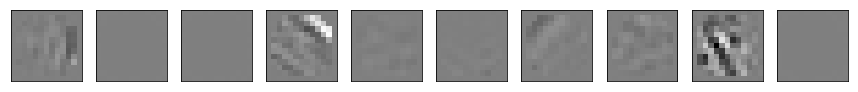

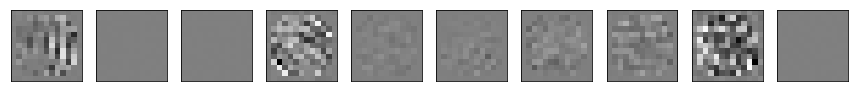

average of data patches =  -1.0042947495150989e-05 +/- 0.005973648630595939
average of residual patches =  7.803596390448593e-05 +/- 0.003042618996221927
median energy of data =  0.03022854521092207
average energy of data =  0.05903749734484456 +/- 0.07012868733999604
average energy of residual =  0.02028926249818388 +/- 0.023558803490106323
median energy of residual =  0.010714040421183738
average gain of coding =  3.08120286266265 +/- 0.8459767606284093


In [27]:
P_cum_rec = None # dico.P_cum
gain_rec = np.ones(shl_nohomeo.n_dictionary)

sparse_code = mp(data[indx, :], dico_nohomeo.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum_rec, gain=gain_rec)
patches = sparse_code @ dico_nohomeo.dictionary
error = data[indx, :] - patches

print('number of codes, size of codewords = ', sparse_code.shape)
print('average of codewords = ', sparse_code.mean())
print('average std of codewords = ', sparse_code.std())
print('l0-sparseness of codewords = ', (sparse_code>0).mean(), ' ~= l0/M =', shl_nohomeo.l0_sparseness/shl_nohomeo.n_dictionary)
print('std of the average of individual patches = ', sparse_code.mean(axis=0).std())

print('number of codes, size of reconstructed images = ', patches.shape)

plt.matshow(sparse_code[:N_show, :])
plt.show()
fig, axs = show_data(data[indx, :][:max_patches, :])
plt.show()
fig, axs = show_data(patches[:max_patches, :])
plt.show()
fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(error[:max_patches, :])))
plt.show()
print('average of data patches = ', data[indx, :].mean(), '+/-', data[indx, :].mean(axis=1).std())
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
SD = np.sqrt(np.mean(data[indx, :]**2, axis=1))

print('median energy of data = ', np.median(SD))
print('average energy of data = ', SD.mean(), '+/-', SD.std())

SE = np.sqrt(np.mean(error**2, axis=1))

print('average energy of residual = ', SE.mean(), '+/-', SE.std())
print('median energy of residual = ', np.median(SE))
print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())

### Shuffling the coefficients

(2048, 441)


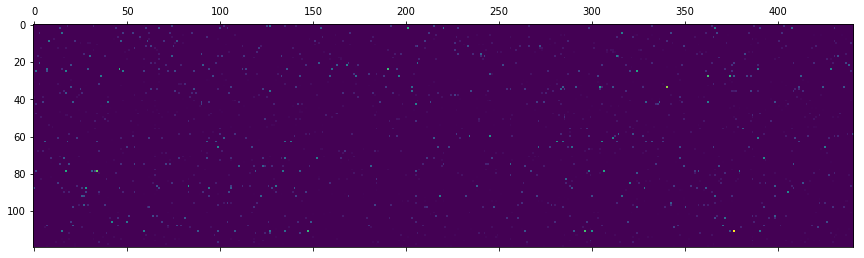

In [28]:
sparse_code_bar = sparse_code.copy()
np.random.shuffle(sparse_code_bar)


print(sparse_code_bar.shape)
plt.matshow(sparse_code_bar[:N_show, :])

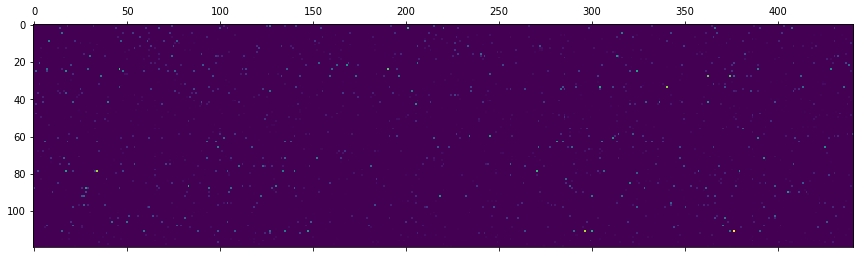

In [29]:
patches_bar = sparse_code_bar @ dico_nohomeo.dictionary
sparse_code_rec = mp(patches_bar, dico_nohomeo.dictionary, l0_sparseness=l0_sparseness, P_cum=P_cum_rec, gain=gain_rec)

plt.matshow(sparse_code_rec[:N_show, :])

In [30]:
print('mean deviation of coefficients = ', np.mean(np.abs(sparse_code_rec)))
print('total deviation of coefficients = ', np.mean(np.abs(sparse_code_bar-sparse_code_rec)))

mean deviation of coefficients =  0.005130256193671742
total deviation of coefficients =  0.0015535173908413468


In [31]:
if not dico_nohomeo.P_cum is None: 
    q_rec = quantile(dico_nohomeo.P_cum, rescaling(sparse_code_rec, C=C), stick, do_fast=False)
    q_bar = quantile(dico_nohomeo.P_cum, rescaling(sparse_code_bar, C=C), stick, do_fast=False)

    print('mean deviation of quantiles = ', np.mean(np.abs(q_bar)))
    print('total deviation of quantiles = ', np.mean(np.abs(q_bar-q_rec)))

In [32]:
print(' correct coefficients = ', np.mean( (sparse_code_bar>0) == (sparse_code_rec>0)))

 correct coefficients =  0.9913570897108843


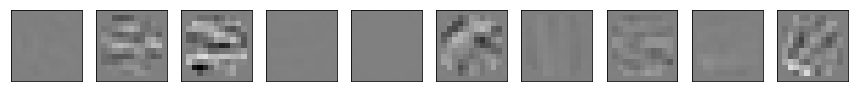

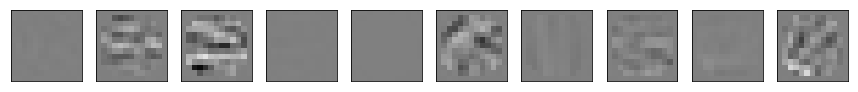

average of data patches =  -8.807891139963685e-05 +/- 0.005177629708824567
average of residual patches =  -1.738024525391803e-05 +/- 0.00103893694451542
median energy of data =  0.028052873545721037
average energy of data =  0.054891142186329206 +/- 0.06582685455957583
average energy of residual =  0.007566378588878514 +/- 0.01000358783409103
median energy of residual =  0.003557070602089555
average gain of coding =  9.611282713916934 +/- 5.455048399336546


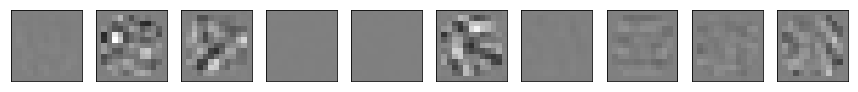

In [33]:
patches_rec = sparse_code_rec @ dico_nohomeo.dictionary
error = patches_bar - patches_rec
fig, axs = show_data(patches_bar[:max_patches, :], cmax=np.max(np.abs(patches_bar[:max_patches, :])))
plt.show()
fig, axs = show_data(patches_rec[:max_patches, :], cmax=np.max(np.abs(patches_bar[:max_patches, :])))
plt.show()
fig, axs = show_data(error[:max_patches, :], cmax=np.max(np.abs(error[:max_patches, :])))
print('average of data patches = ', patches_bar.mean(), '+/-', patches_bar.mean(axis=1).std())
print('average of residual patches = ', error.mean(), '+/-', error.mean(axis=1).std())
SD = np.sqrt(np.mean(patches_bar**2, axis=1))
print('median energy of data = ', np.median(SD))
print('average energy of data = ', SD.mean(), '+/-', SD.std())

SE = np.sqrt(np.mean(error**2, axis=1))

print('average energy of residual = ', SE.mean(), '+/-', SE.std())
print('median energy of residual = ', np.median(SE))
print('average gain of coding = ', (SD/SE).mean(), '+/-', (SD/SE).std())

## Version used

In [34]:
%load_ext version_information
%version_information numpy, shl_scripts, pandas

Software versions
Python 3.6.4 64bit [GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.39.2)]
IPython 6.2.1
OS Darwin 17.4.0 x86_64 i386 64bit
numpy 1.14.0
shl_scripts 20171221
pandas 0.22.0
Mon Feb 12 17:39:13 2018 CET